In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

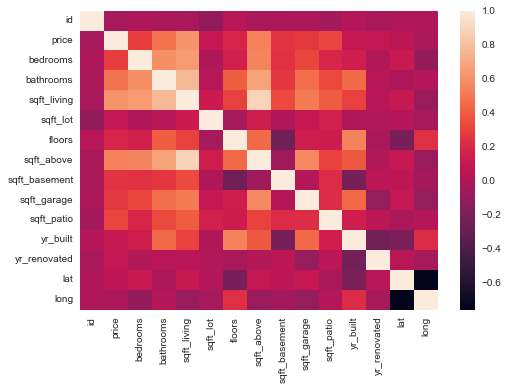

In [4]:
sns.heatmap(df.corr());

In [5]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [7]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [8]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [9]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Bedrooms

In [10]:
bedrooms_count = print(df['bedrooms'].value_counts())

3     12754
4      9597
2      3936
5      2798
6       498
1       391
7        80
0        44
8        38
9        14
10        3
11        1
13        1
Name: bedrooms, dtype: int64


In [11]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]

In [12]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins=[0,1,2,3,4,5,6,99], labels=['1_bed','2_bed','3_bed','4_bed','5_bed','6_bed','7+_bed'])

### Price

In [13]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q25, price_q75 = np.percentile(df['price'], [25, 75])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -330000.0 
price_max: 2278000.0


In [14]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [15]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3378.0 
sqft_lot_max: 18246.0


In [16]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Floors

In [17]:
floor_count = print(df['floors'].value_counts())

1.0    11895
2.0     9771
1.5     2055
3.0     1134
2.5      127
4.0       30
3.5       15
Name: floors, dtype: int64


In [18]:
df = df[df['floors'] != 4.0]
df = df[df['floors'] != 3.5]

### Grade

In [19]:
grade_count = print(df['grade'].value_counts())

7 Average        10679
8 Good            8175
9 Better          2690
6 Low Average     2553
10 Very Good       495
5 Fair             293
11 Excellent        55
4 Low               31
3 Poor               8
12 Luxury            3
Name: grade, dtype: int64


In [20]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

# Train-Test Split

In [21]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Categorical Variables

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24971 entries, 0 to 30154
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             24971 non-null  int64         
 1   date           24971 non-null  datetime64[ns]
 2   price          24971 non-null  float64       
 3   bedrooms       24971 non-null  int64         
 4   bathrooms      24971 non-null  float64       
 5   sqft_living    24971 non-null  int64         
 6   sqft_lot       24971 non-null  int64         
 7   floors         24971 non-null  float64       
 8   waterfront     24971 non-null  object        
 9   greenbelt      24971 non-null  object        
 10  nuisance       24971 non-null  object        
 11  view           24971 non-null  object        
 12  condition      24971 non-null  object        
 13  grade          24971 non-null  object        
 14  heat_source    24955 non-null  object        
 15  sewer_system   2496

In [23]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      16
sewer_system      8
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
bedrooms_bin     28
dtype: int64

In [24]:
df.dropna(inplace=True)

In [25]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
bedrooms_bin     0
dtype: int64

In [26]:
#drop the 33 bedroom outlier 
df.drop(['date', 'sqft_garage', 'sqft_basement'], axis=1, inplace=True)
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode,bedrooms_bin
0,7399300360,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,PUBLIC,1180,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,4_bed
1,8910500230,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,PUBLIC,1570,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,5_bed
2,1180000275,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,PUBLIC,1580,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,6_bed
3,1604601802,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,PUBLIC,1090,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,3_bed
4,8562780790,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,PUBLIC,1120,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,2_bed


### Bedroom Bins

In [27]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

In [28]:
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,long,zipcode,bedrooms_bin,bedrooms_bin_x0_2_bed,bedrooms_bin_x0_3_bed,bedrooms_bin_x0_4_bed,bedrooms_bin_x0_5_bed,bedrooms_bin_x0_6_bed,bedrooms_bin_x0_7+_bed,bedrooms_bin_x0_nan
29151,8010100195,2022-04-12,3,3.0,1940,4625,2.0,NO,NO,NO,...,-122.388940,98116,3_bed,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25077,6699000610,2021-09-01,3,2.5,2460,5027,2.0,NO,NO,YES,...,-122.102170,98042,3_bed,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10286,6762700370,2021-07-06,3,3.0,1550,1215,2.0,NO,NO,YES,...,-122.320637,98102,3_bed,0.0,1.0,0.0,0.0,0.0,0.0,0.0
502,4046710330,2021-12-01,3,2.5,1620,16606,2.0,NO,NO,NO,...,-121.913060,98014,3_bed,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10979,1775920020,2021-10-15,3,3.0,2600,9450,1.0,NO,NO,NO,...,-122.103920,98072,3_bed,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Condition

In [29]:
condition_count = df['condition'].value_counts()
condition_count

Average      15491
Good          6569
Very Good     2670
Fair           154
Poor            37
Name: condition, dtype: int64

In [30]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [31]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [32]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [33]:
floor_count = print(df['floors'].value_counts())

1.0    11872
2.0     9752
1.5     2051
3.0     1119
2.5      127
Name: floors, dtype: int64


In [34]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [35]:
X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [36]:
X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [37]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### View

In [38]:
X_train['view'].isna().sum()

0

In [39]:
view_count = df['view'].value_counts()
view_count

NONE         22715
AVERAGE       1357
GOOD           499
EXCELLENT      188
FAIR           162
Name: view, dtype: int64

In [40]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [41]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [42]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [43]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [44]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [45]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [46]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

### Zipcode

In [47]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [48]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -1.907619948449124e-06


In [49]:
df.corr()['price'].abs().sort_values(ascending=False)

price           1.000000
sqft_living     0.556878
sqft_above      0.454500
bathrooms       0.425738
bedrooms        0.320293
sqft_patio      0.226745
floors          0.185151
lat             0.083383
yr_renovated    0.065320
sqft_lot        0.059200
yr_built        0.050103
long            0.029200
zipcode         0.026609
id              0.013460
Name: price, dtype: float64

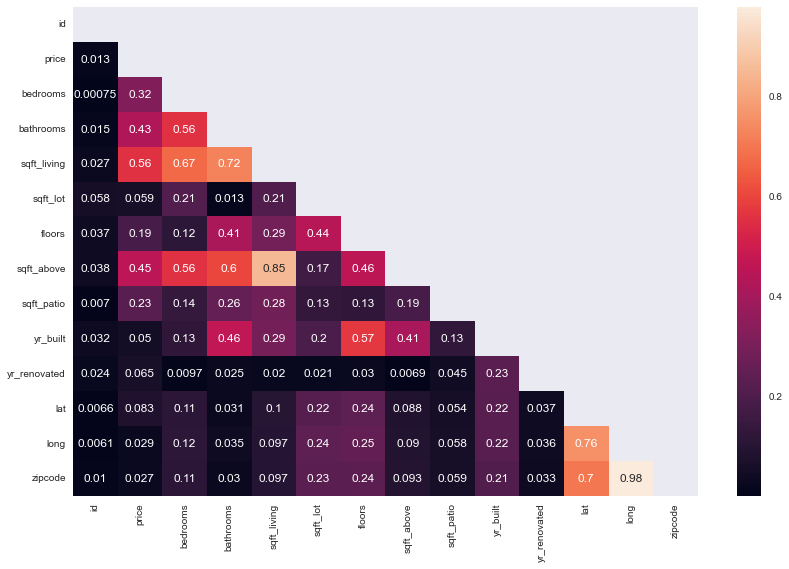

In [50]:
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    f.savefig('images/Corelation Heatmap',bbox_inches="tight")

### Model 1

In [51]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [52]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3089788970399302
    test score: 0.31219525807903226


In [53]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                 1.120e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:43:45   Log-Likelihood:            -3.5378e+05
No. Observations:               24921   AIC:                         7.076e+05
Df Residuals:                   24919   BIC:                         7.076e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.188e+05   6150.683     51.828      0.000    3.07e+05    3.31e+05
sqft_living   313.3114      2.960    105.837      0.000     307.509     319.114
==============================================================================
Omnibus:                     1376.678   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1725.245
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.664   Cond. No.                     5.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [54]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [55]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.68232984536161
    test score: 0.6665717554969071


In [56]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.682
Mean Absolute Error: 169398.066
Mean Squared Error: 57663623009.842
Root Mean Squared Error: 240132.511

Testing Metrics:
R2: 0.667
Mean Absolute Error: 172847.474
Mean Squared Error: 60584987756.073
Root Mean Squared Error: 246140.179


### Model 2b

In [57]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [58]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3105926934896127
    test score: 0.3138961603080127


In [59]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.311
Mean Absolute Error: 275761.115
Mean Squared Error: 125141510596.417
Root Mean Squared Error: 353753.460

Testing Metrics:
R2: 0.314
Mean Absolute Error: 275340.538
Mean Squared Error: 124667281228.925
Root Mean Squared Error: 353082.542


### Model 3

In [60]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [61]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3152305604396356
    test score: 0.3147910644320806


In [62]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.315
Mean Absolute Error: 274238.210
Mean Squared Error: 124299642994.217
Root Mean Squared Error: 352561.545

Testing Metrics:
R2: 0.315
Mean Absolute Error: 274627.317
Mean Squared Error: 124504674262.379
Root Mean Squared Error: 352852.199


### Model 3b

In [63]:
cols = ['sqft_living', 'sqft_living15'] + encoded_bedrooms_bins + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [64]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.684693764223347
    test score: 0.6682086135517977


In [65]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.685
Mean Absolute Error: 168988.327
Mean Squared Error: 57234523442.008
Root Mean Squared Error: 239237.379

Testing Metrics:
R2: 0.668
Mean Absolute Error: 173042.267
Mean Squared Error: 60287565366.552
Root Mean Squared Error: 245535.263


### Model 4

In [66]:
cols = ['bedrooms', 'sqft_living'] + encoded_condition + encoded_zipcode 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [67]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6889248543225941
    test score: 0.6725081468828618


In [68]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.689
Mean Absolute Error: 166623.532
Mean Squared Error: 56466494148.600
Root Mean Squared Error: 237626.796

Testing Metrics:
R2: 0.673
Mean Absolute Error: 170753.322
Mean Squared Error: 59506326288.838
Root Mean Squared Error: 243939.186


### Model 4b

In [69]:
cols = ['sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [70]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6908136621443169
    test score: 0.6736796308013397


In [71]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.691
Mean Absolute Error: 166274.157
Mean Squared Error: 56123636940.960
Root Mean Squared Error: 236904.278

Testing Metrics:
R2: 0.674
Mean Absolute Error: 170799.066
Mean Squared Error: 59293463881.326
Root Mean Squared Error: 243502.493


### Model 5

In [72]:
cols = ['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'view'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [73]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6972486714353232
    test score: 0.6808945128193529


In [74]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.697
Mean Absolute Error: 164311.050
Mean Squared Error: 54955551288.583
Root Mean Squared Error: 234426.004

Testing Metrics:
R2: 0.681
Mean Absolute Error: 167954.994
Mean Squared Error: 57982496541.489
Root Mean Squared Error: 240795.549


### Model 5b

In [75]:
cols = ['bathrooms', 'sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [76]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7006470602444432
    test score: 0.6831452281032151


In [77]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.701
Mean Absolute Error: 163661.881
Mean Squared Error: 54338674291.268
Root Mean Squared Error: 233106.573

Testing Metrics:
R2: 0.683
Mean Absolute Error: 168204.917
Mean Squared Error: 57573534312.994
Root Mean Squared Error: 239944.857


### Model 6

In [78]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [79]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6988045733191203
    test score: 0.6817022825884351


In [80]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 163995.234
Mean Squared Error: 54673123309.884
Root Mean Squared Error: 233822.846

Testing Metrics:
R2: 0.682
Mean Absolute Error: 168079.740
Mean Squared Error: 57835722168.363
Root Mean Squared Error: 240490.586


### Model 6b

In [81]:
cols = ['bathrooms', 'sqft_living', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [82]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7006691844150505
    test score: 0.683012085519833


In [83]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.701
Mean Absolute Error: 163700.709
Mean Squared Error: 54334658302.310
Root Mean Squared Error: 233097.959

Testing Metrics:
R2: 0.683
Mean Absolute Error: 168254.937
Mean Squared Error: 57597726749.948
Root Mean Squared Error: 239995.264


### Model 7

In [84]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [85]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6988045733191203
    test score: 0.6817022825884351


In [86]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 163995.234
Mean Squared Error: 54673123309.884
Root Mean Squared Error: 233822.846

Testing Metrics:
R2: 0.682
Mean Absolute Error: 168079.740
Mean Squared Error: 57835722168.363
Root Mean Squared Error: 240490.586


### Model 7b

In [87]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [88]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7006691844150505
    test score: 0.683012085519833


In [89]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.701
Mean Absolute Error: 163700.709
Mean Squared Error: 54334658302.310
Root Mean Squared Error: 233097.959

Testing Metrics:
R2: 0.683
Mean Absolute Error: 168254.937
Mean Squared Error: 57597726749.948
Root Mean Squared Error: 239995.264


### Model 8

In [90]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [91]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6911493678417335
    test score: 0.6740969164800565


In [92]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.691
Mean Absolute Error: 166204.158
Mean Squared Error: 56062699498.473
Root Mean Squared Error: 236775.631

Testing Metrics:
R2: 0.674
Mean Absolute Error: 170670.174
Mean Squared Error: 59217641727.227
Root Mean Squared Error: 243346.752


### Model 9

In [93]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [94]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7192120707111482
    test score: 0.7093721485071913


In [95]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.719
Mean Absolute Error: 158346.018
Mean Squared Error: 50968745611.804
Root Mean Squared Error: 225762.587

Testing Metrics:
R2: 0.709
Mean Absolute Error: 161654.452
Mean Squared Error: 52808018260.440
Root Mean Squared Error: 229799.953


### Model 10

In [96]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [97]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7004487145135774
    test score: 0.6826373534862028


In [98]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.700
Mean Absolute Error: 163770.358
Mean Squared Error: 54374678093.587
Root Mean Squared Error: 233183.786

Testing Metrics:
R2: 0.683
Mean Absolute Error: 168374.218
Mean Squared Error: 57665816769.446
Root Mean Squared Error: 240137.079


### Model 11

In [99]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [100]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7020229499485455
    test score: 0.6811240738916278


In [101]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.702
Mean Absolute Error: 163509.702
Mean Squared Error: 54088922200.800
Root Mean Squared Error: 232570.252

Testing Metrics:
R2: 0.681
Mean Absolute Error: 168550.407
Mean Squared Error: 57940784554.030
Root Mean Squared Error: 240708.921


### Model 11b

In [102]:
cols = ['floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [103]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7005715375574765
    test score: 0.6833118117147947


In [104]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.701
Mean Absolute Error: 163818.627
Mean Squared Error: 54352383201.867
Root Mean Squared Error: 233135.976

Testing Metrics:
R2: 0.683
Mean Absolute Error: 168356.840
Mean Squared Error: 57543265533.326
Root Mean Squared Error: 239881.774


### Model 12

In [105]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [106]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7204771019341121
    test score: 0.707840146472128


In [107]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.720
Mean Absolute Error: 157925.826
Mean Squared Error: 50739116600.480
Root Mean Squared Error: 225253.450

Testing Metrics:
R2: 0.708
Mean Absolute Error: 161770.269
Mean Squared Error: 53086387972.865
Root Mean Squared Error: 230404.835


### Model 12b

In [108]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [109]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7192806597995327
    test score: 0.709156889358679


In [110]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.719
Mean Absolute Error: 158315.639
Mean Squared Error: 50956295290.999
Root Mean Squared Error: 225735.011

Testing Metrics:
R2: 0.709
Mean Absolute Error: 161614.052
Mean Squared Error: 52847131542.209
Root Mean Squared Error: 229885.040


### Model 13

In [111]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [112]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7194887964600178
    test score: 0.7090467591953663


In [113]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.719
Mean Absolute Error: 158204.004
Mean Squared Error: 50918514234.928
Root Mean Squared Error: 225651.311

Testing Metrics:
R2: 0.709
Mean Absolute Error: 161534.685
Mean Squared Error: 52867142548.193
Root Mean Squared Error: 229928.560


### Model 14

In [114]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [115]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7200217318125802
    test score: 0.7101396435050835


In [116]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.720
Mean Absolute Error: 158011.916
Mean Squared Error: 50821775580.666
Root Mean Squared Error: 225436.855

Testing Metrics:
R2: 0.710
Mean Absolute Error: 161071.723
Mean Squared Error: 52668561943.176
Root Mean Squared Error: 229496.322


### Model 15

In [117]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [118]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.702806915583734
    test score: 0.6825201573987683


In [119]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.703
Mean Absolute Error: 163222.834
Mean Squared Error: 53946616421.739
Root Mean Squared Error: 232264.109

Testing Metrics:
R2: 0.683
Mean Absolute Error: 167947.466
Mean Squared Error: 57687111676.639
Root Mean Squared Error: 240181.414
